## Content table
1. Problem statement.
2. Data gathering and preparation.
3. Choice of the tartget variable.
4. Building baseline predictions. 
5. Gathering data for additional drivers.
6. Building daily predictions with additional drivers. 
7. Building predictions for the daily profile. 
8. Compiling models to end to end pipeline. 
9.  Conclusion.
10. Next steps.

## Problem statement.

The current paper will analyse the data from 300 Australian households, which provided data about their energy consumption and solar battery production. Then, we build a forecast for the solar production using this data and additional drivers as day length and the weather.

## Data gathering and preparation
Ausgrid provides the  [information](https://www.ausgrid.com.au/Industry/Our-Research/Data-to-share/Solar-home-electricity-data) about 300 randomly selected australian households with solar batteries. 
The data is divided by three parts (07.2010 -- 07.2011,  07.2011 -- 07.2012, 07.2012 -- 07.2013). 
The structure of the files is the same through all files, so it can be relatively easy to concatente them.
Most of households provide information for only one year but some of them provided information for the whole period.
Let's take a look how the data is structured. 

In [143]:
import pandas as pd
import numpy as np
from prophet import Prophet
from gather_data import gather_files, concat_files
import datetime

In [8]:
list_files = ['2010-2011_Solar_home_electricity_data.csv', 
'2011-2012_Solar_home_electricity_data_v2.csv', '2012-2013_Solar_home_electricity_data_v2.csv']
df = concat_files(list_files)

The resulting dataframe looks like:

In [22]:
df.head()

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
0,1,3.78,2076,GC,1-Jul-10,0.303,0.471,0.083,0.121,0.361,...,0.54,0.406,0.543,0.495,0.216,0.378,0.128,0.078,0.125,NaN
1,1,3.78,2076,CL,1-Jul-10,1.250,1.244,1.256,0.744,0.019,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.075,NaN
2,1,3.78,2076,GG,1-Jul-10,0.000,0.000,0.000,0.000,0.000,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
3,1,3.78,2076,GC,2-Jul-10,0.116,0.346,0.122,0.079,0.120,...,1.10,1.012,0.817,0.526,0.335,0.402,0.142,0.120,0.111,NaN
4,1,3.78,2076,CL,2-Jul-10,1.238,1.238,1.256,1.250,0.169,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.088,NaN


Every row is responsible for the one day for the one customer for the type of consumption/production.
Customer: customer identifier; 
Generator Capacity: capacity of the generator installed in this household.
Postcode: 4-letter postocde in Australia. 
Consumption category:
There are three types of the consumption/production:
* GC -- general consumption;
* CL -- consumtion happened in off-pick tarrif;
* GG -- generation of the energy via solar panel.
Date: date in formats: dd-mon-yy, dd/mon/yy, dd/mm/yy.
0:30 -- 00:00: amount  of generated/consumpted energy during the half of an hour interval at the date from the column date. 


This format is not suitable for further investigation so we'll transform it. 
Transposition of the production values: 

In [9]:
def transform_row(i):
       temp = df.loc[i].T
       df1 = temp[['0:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00',
              '4:30', '5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00', '8:30',
              '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30',
              '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
              '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
              '21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '0:00']]
       df1 = pd.DataFrame(df1)
       df1.rename(columns={i: "Production"}, inplace=True)
       df1['time'] = df1.index
       df1.reset_index()
       df1['datetime'] = temp['date'] + " " + df1.index
       df1['date'] = temp['date']
       df1['Customer'] = temp['Customer']
       df1['Generator Capacity'] = temp['Generator Capacity']
       df1["Postcode"] = temp['Postcode']
       df1["Consumption Category"] = temp['Consumption Category']
       return df1

In [10]:
dfs = []
for i in range(df.shape[0]):
    temp = transform_row(i)
    dfs.append(temp)
df_full = pd.concat([*dfs], axis=0)

In [11]:
df_full.head()

,Production,time,datetime,date,Customer,Generator Capacity,Postcode,Consumption Category
0:30,0.303,0:30,1-Jul-10 0:30,1-Jul-10,1,3.78,2076,GC
1:00,0.471,1:00,1-Jul-10 1:00,1-Jul-10,1,3.78,2076,GC
1:30,0.083,1:30,1-Jul-10 1:30,1-Jul-10,1,3.78,2076,GC
2:00,0.121,2:00,1-Jul-10 2:00,1-Jul-10,1,3.78,2076,GC
2:30,0.361,2:30,1-Jul-10 2:30,1-Jul-10,1,3.78,2076,GC


Since there are used different formats for datetime, it's needed to transform all of them to one format:

In [13]:
df_full['datetime_f'] = pd.to_datetime(df_full['datetime'], format='%d-%b-%y %H:%M', errors='ignore')
df_full['datetime_f2'] = pd.to_datetime(df_full['datetime'], format='%d/%b/%y %H:%M', errors='ignore')
df_full['Timestamp'] = np.where(df_full['datetime_f'].isna(), df_full['datetime_f2'], df_full['datetime_f'])
df_full['datetime_f'] = df_full['Timestamp']
df_full = df_full.sort_values('datetime_f')
sample_full = df_full.set_index(['datetime_f', 'Consumption Category', "Customer"]).unstack(['Consumption Category'])[['Production']]


Resulting dataframe looks like this: 

In [16]:
sample_full.reset_index().set_index('datetime_f')

Customer Production              
Consumption Category                  CL     GC     GG
datetime_f                                            
1-Apr-11 0:00               1        0.0  0.613    0.0
1-Apr-11 0:00               2        0.0  0.155    0.0
1-Apr-11 0:00               3        0.0  0.178    0.0
1-Apr-11 0:00               4        0.0  0.114    0.0
1-Apr-11 0:00               5      1.825  0.078    0.0
...                       ...        ...    ...    ...
9/12/2012 9:30            296        NaN  0.262  0.338
9/12/2012 9:30            297        0.0  0.192  0.057
9/12/2012 9:30            298        NaN  0.165  0.188
9/12/2012 9:30            299        NaN   0.13  0.269
9/12/2012 9:30            300        0.0  1.538  0.581

[15778512 rows x 4 columns]

## Choice of the tartget variable.

The main interest are variables in the Production column. Let's see how this data is distributed. 

In [ ]:
sample_full_copy.set_index(['datetime_f', 'Consumption Category', "Customer"]).unstack(['Consumption Category'])[['Production']]
full_aggregated = sample_full.reset_index().groupby('datetime_f').agg({'sum', 'count'})
full_aggregated.index = pd.to_datetime(full_aggregated.index)

Solar production:

<AxesSubplot:xlabel='datetime_f'>

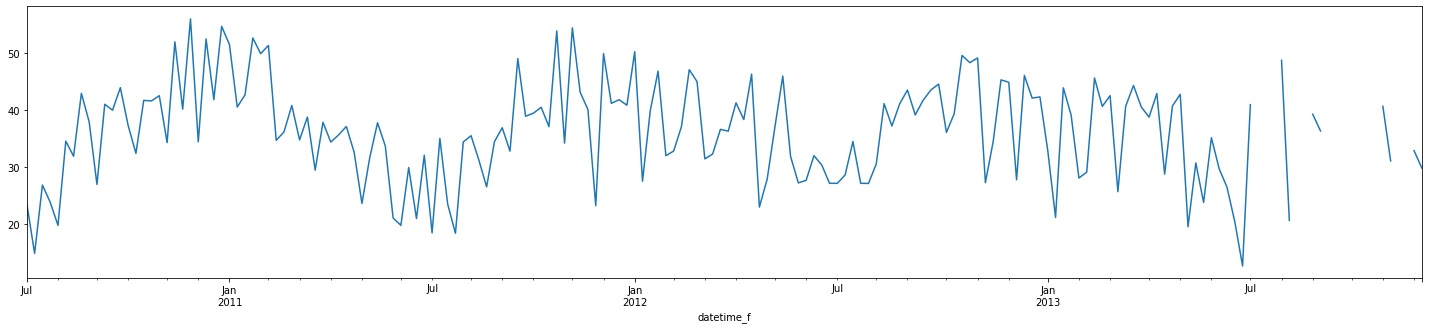

In [20]:
full_aggregated[('Production', 'GG', 'sum')].resample("W").mean().plot(figsize=(25, 5))

General consumption:

<AxesSubplot:xlabel='datetime_f'>

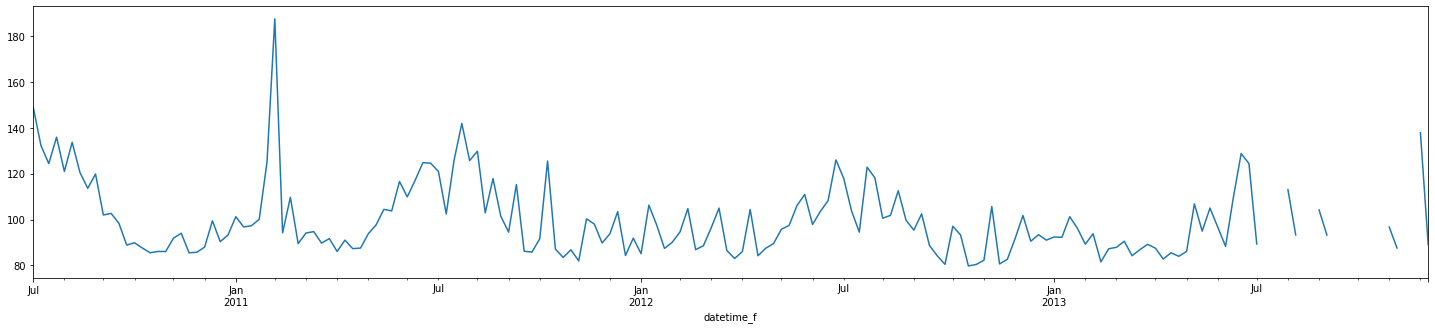

In [21]:
full_aggregated[('Production', 'GC', 'sum')].resample("W").mean().plot(figsize=(25, 5))

Off-peak consumption:

<AxesSubplot:xlabel='datetime_f'>

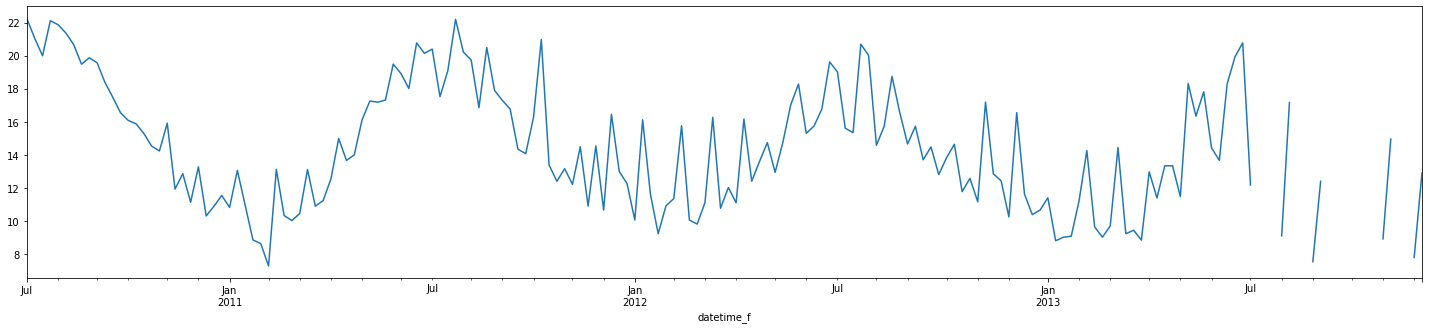

In [22]:
full_aggregated[('Production', 'CL', 'sum')].resample("W").mean().plot(figsize=(25, 5))

For all three parameters, the data becomes partial after July 2013. Supposedly, measurements from some of the client either were not taken or mistakenly placed there. There is no way to figure it out, this data will be discarded.

Which variable we are going to use for the preidction? Following candidates were considered: 
* Solar production
* Difference between current production and energy consumption 
* Profit between consumpted energy and solar production

Potentialy, all these three variables could be useful for a potential user of the solar battery. First one gives information about the solar production. The second and third give information about the profit that user can receive if they send extra produced energy to a grid. 

In [25]:
full_aggregated['Production']['GG']

,count,sum
datetime_f,,
2011-04-01 00:00:00,300,0.013
2011-04-01 00:30:00,300,0.018
2011-04-01 10:00:00,300,92.382
2011-04-01 10:30:00,300,109.83
2011-04-01 11:00:00,300,115.701
...,...,...
2012-09-12 07:30:00,299,22.564
2012-09-12 08:00:00,299,41.142
2012-09-12 08:30:00,299,66.805


All three possible target variables in one plot:

![target_variabl](target_variable2.png)

Orange and green lines describe variables difference between the production and consumption and the profit respectfully, and the blue one is the pure production. 
If we had an actual user with a real time solar battery and consumption of the household, we could predict the best (the cheapest, the greenest) time for a user to consume a lot of energy (for example, to charge a car). But these metrics are valuable when the user has an immediate feedback and user can act on it. In abscense of the real user and having only historical data, there is not much sense in such predictions therefore, the production of solar battery was chosen as a target variable. 

The target variable contains many near 0 values. Because of it, it makes sense to choose use wape (weighted absolute percentage error) as a metrics for quality.

$WAPE = \frac{ \sum_{t=1}^{n} \|A_t - F_t\| }{\sum_{t=1}^{n} \|A_t|}$

Here $A_t$ -- actual measurements, $F_t$ predictions.

## Building baseline predictions.

To establish a baseline for prediction, we'll build a model using [Prophet](https://facebook.github.io/prophet/) without having any adjustments. To simplify the explanation of the problem and to be able to calculate, here will be considered only one customer, and a prediction is built for it. 

To have widest data range, the customer `id=224` was chosen since it has a data for 2010 - 2013 years. 

In [280]:
full_hourly = pd.read_csv('full_hourly.csv')

/Users/olgas/study/solar-forecast/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [357]:
hourly_224 = full_hourly[full_hourly['Customer'] == 224]
hourly_224 = hourly_224[hourly_224['Consumption Category'] == 'GG']

Since the target variable is chosen as solar production, all rows with the household consumption data can be discarded.

In [358]:
hourly_224['datetime_f1'] = pd.to_datetime(hourly_224['datetime'], format='%d-%b-%y %H:%M', errors='coerce')
hourly_224['datetime_f2'] = pd.to_datetime(hourly_224['datetime'], format='%d/%b/%y %H:%M', errors='coerce')
hourly_224['datetime_f3'] = pd.to_datetime(hourly_224['datetime'], format='%d/%m/%Y %H:%M', errors='coerce')
hourly_224['Timestamp'] = np.where(hourly_224['datetime_f1'].isna(), hourly_224['datetime_f2'], hourly_224['datetime_f1'])
hourly_224['Timestamp'] = np.where(hourly_224['Timestamp'].isna(), hourly_224['datetime_f3'], hourly_224['Timestamp'])
hourly_224['datetime_f'] = hourly_224['Timestamp']

In [359]:
hourly_224['datetime_f'] = hourly_224['Timestamp']
hourly_224 = hourly_224.reset_index(drop=True).set_index('datetime_f')

In [360]:
hourly_224 = hourly_224.drop(['datetime_f1', 'datetime_f2', 'datetime_f3'], axis=1)

As a train set here and in further calculations will be used data from the beginning of the period (2010-07-01) and till the 2013-01-01. The last 6 month (till the 2013-07-01) will be used as a test set. 

In [381]:
hourly_224['ds'] = hourly_224['Timestamp']

hourly_224['y'] = hourly_224['Production']

hourly_224_train = hourly_224[hourly_224['datetime'] <= '2013-01-01']
hourly_224_test = hourly_224[(hourly_224['datetime'] > '2013-01-01')]
hourly_224_train = hourly_224_train.drop(['datetime','date', 'Consumption Category', 'Generator Capacity', 'Unnamed: 0'], axis=1)
hourly_224_test = hourly_224_test.drop(['datetime','date', 'Consumption Category', 'Generator Capacity', 'Unnamed: 0'], axis=1)

In [382]:
model_hourly = Prophet()
model_hourly.fit(hourly_224_train)
future = model_hourly.make_future_dataframe(periods=7680, freq='30min')

Initial log joint probability = -1013.26
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       31521.1    0.00197624       421.067           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       31526.7   0.000657175       91.4082           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       31528.5   0.000150396       174.214   1.587e-06       0.001      366  LS failed, Hessian reset 
     299       31528.9    0.00041358       72.8549      0.4276           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373       31529.4   1.55384e-06       63.2323      0.2311           1      490   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [383]:
forecast_hourly = model_hourly.predict(future)
y_test = hourly_224_test['y']
y_pred = forecast_hourly['yhat']

In [384]:

wape = np.sum(np.abs((y_pred - y_test.reset_index(drop=True))) / np.sum(y_test.reset_index(drop=True))) * 100
wape

72.67082267487797

The Prophet model without any additional actions gives around WAPE 72%. This number can be considered as a baseline for the other models. 

## Gathering data for additional drivers.

We can assume that solar production depends on the geographical coordinates of the place where battery is placed. Since the calculation for the production is happening for the particular customer, this is not a driver in this case. But the time of the sunrise and the sunset definetely should be a driver.

The other important variable that should be considered is the weather. The infomration about the precipitation and the temperature during the day was found but unfortunatelly, it wasn't available.


The weather data is taken from [http://www.bom.gov.au](http://www.bom.gov.au/climate/data-services/station-data.shtml)

Gathering the data and merging it with the main dataset.

In [27]:
year = '2010'
initial_df = pd.read_csv(f'data/2010.csv', header=0)
initial_df['day'] = initial_df[year]
initial_df.drop([year], inplace=True, axis=1)
s = pd.DataFrame(initial_df.set_index(['day']).unstack(['day']))
df = pd.DataFrame(s.to_records(), index=s.index).reset_index(drop=True)[['level_0', 'day', '0']].reset_index(drop=True)
df['date'] = df['day'].astype(str) + "-" + df['level_0'] + f'-{year}'
df = df[['0', 'date']].dropna()
df['date'] = pd.to_datetime(df['date'])
weather_2010_df = df
year = '2011'
initial_df = pd.read_csv(f'data/2011.csv', header=0)
initial_df['day'] = initial_df[year]
initial_df.drop([year], inplace=True, axis=1)
s = pd.DataFrame(initial_df.set_index(['day']).unstack(['day']))
df = pd.DataFrame(s.to_records(), index=s.index).reset_index(drop=True)[['level_0', 'day', '0']].reset_index(drop=True)
df['date'] = df['day'].astype(str) + "-" + df['level_0'] + f'-{year}'
df = df[['0', 'date']].dropna()
df['date'] = pd.to_datetime(df['date'])
weather_2011_df = df
year = '2012'
initial_df = pd.read_csv(f'data/2012.csv', header=0)
initial_df['day'] = initial_df[year]
initial_df.drop([year], inplace=True, axis=1)
s = pd.DataFrame(initial_df.set_index(['day']).unstack(['day']))
df = pd.DataFrame(s.to_records(), index=s.index).reset_index(drop=True)[['level_0', 'day', '0']].reset_index(drop=True)
df['date'] = df['day'].astype(str) + "-" + df['level_0'] + f'-{year}'
df = df[['0', 'date']].dropna()
df['date'] = pd.to_datetime(df['date'])
weather_2012_df = df
year = '2013'
initial_df = pd.read_csv(f'data/2013.csv', header=0)
initial_df['day'] = initial_df[year]
initial_df.drop([year], inplace=True, axis=1)
s = pd.DataFrame(initial_df.set_index(['day']).unstack(['day']))
df = pd.DataFrame(s.to_records(), index=s.index).reset_index(drop=True)[['level_0', 'day', '0']].reset_index(drop=True)
df['date'] = df['day'].astype(str) + "-" + df['level_0'] + f'-{year}'
df = df[['0', 'date']].dropna()
df['date'] = pd.to_datetime(df['date'])
weather_2013_df = df

In [28]:
weather = pd.concat([weather_2010_df, weather_2011_df, weather_2012_df, weather_2013_df])

In [184]:
hourly_224['date'] = pd.to_datetime(hourly_224['date'])
hourly_224_weather = hourly_224.merge(weather, how='left', on='date')

In [163]:
hourly_224_weather.fillna({'0':0}, inplace=True)

Checking if the weather alone will affect the quality of the prediction. All other parameters stay the same, test and train datasets are splitted the same way, the only difference is adding a regressor to a model:

In [96]:
hourly_224_weather['ds'] = hourly_224_weather['Timestamp']

hourly_224_weather['y'] = hourly_224_weather['Production']

hourly_224_train = hourly_224_weather[hourly_224_weather['datetime'] <= '2013-01-01']
hourly_224_test = hourly_224_weather[(hourly_224_weather['datetime'] > '2013-01-01') & (hourly_224_weather['datetime'] > '2013-07-01')]
hourly_224_train.drop(['datetime','date', 'Consumption Category', 'datetime_f1', 'datetime_f2', 'datetime_f3', 'Generator Capacity', 'Unnamed: 0'], axis=1)

,Production,time,Customer,Postcode,Timestamp,ds,y,0
0,0.0,0:30,224,2261,2010-07-01 00:30:00,2010-07-01 00:30:00,0.0,0.0
1,0.0,1:00,224,2261,2010-07-01 01:00:00,2010-07-01 01:00:00,0.0,0.0
2,0.0,1:30,224,2261,2010-07-01 01:30:00,2010-07-01 01:30:00,0.0,0.0
3,0.0,2:00,224,2261,2010-07-01 02:00:00,2010-07-01 02:00:00,0.0,0.0
4,0.0,2:30,224,2261,2010-07-01 02:30:00,2010-07-01 02:30:00,0.0,0.0
...,...,...,...,...,...,...,...,...
52123,0.0,22:00,224,2261,2013-06-20 22:00:00,2013-06-20 22:00:00,0.0,1.0
52124,0.0,22:30,224,2261,2013-06-20 22:30:00,2013-06-20 22:30:00,0.0,1.0
52125,0.0,23:00,224,2261,2013-06-20 23:00:00,2013-06-20 23:00:00,0.0,1.0
52126,0.0,23:30,224,2261,2013-06-20 23:30:00,2013-06-20 23:30:00,0.0,1.0


In [97]:
model_hourly = Prophet()
model_hourly.add_regressor('0')

model_hourly.fit(hourly_224_train)

future = model_hourly.make_future_dataframe(periods=7680, freq='30min')
future['0'] = hourly_224_test['0'].reset_index(drop=True)

Initial log joint probability = -1013.26
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       31641.9    0.00201109       117.305           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       31650.1    0.00605686       152.978           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       31654.3   0.000843509        96.757      0.7748      0.7748      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       31655.7   8.56425e-05       144.225   4.472e-07       0.001      434  LS failed, Hessian reset 
     399       31656.8   7.68369e-05       75.4566      0.4227           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       31657.9     0.0190982    

In [99]:
forecast_hourly = model_hourly.predict(future)
y_test = hourly_224_test['y']
y_pred = forecast_hourly['yhat']

In [100]:

wape = np.sum(np.abs((y_pred - y_test.reset_index(drop=True))) / np.sum(y_test.reset_index(drop=True))) * 100
wape

72.63258365577624

The result is better but not significantly. It might happen because the the additional data describes processes on a day level. It makes sense to build a prediction for a day, and  using a different model will build a prediction profile inside one day. 

## Building daily predictions with additional drivers.

Gather informations for drivers and resample original dataset for building a prediction for a day:

In [105]:
temp_2010 = pd.read_csv("data/Temp_max_2010_Data.csv")[['Maximum temperature (Degree C)', 'Year', 'Month', 'Day']]

temp_2010['temp'] = temp_2010["Maximum temperature (Degree C)"]
temp_2010 = temp_2010.drop("Maximum temperature (Degree C)", axis=1)
temp_2010['ds'] = pd.to_datetime(temp_2010['Year'].astype(str) + "-" +  temp_2010['Month'].astype(str) + "-" + temp_2010['Day'].astype(str))
temp_2010['temp'].fillna(method='ffill', inplace=True)

temp_2011 = pd.read_csv("data/Temp_max_2011_Data.csv")[['Maximum temperature (Degree C)', 'Year', 'Month', 'Day']]

temp_2011['temp'] = temp_2011["Maximum temperature (Degree C)"]
temp_2011 = temp_2011.drop("Maximum temperature (Degree C)", axis=1)
temp_2011['ds'] = pd.to_datetime(temp_2011['Year'].astype(str) + "-" +  temp_2011['Month'].astype(str) + "-" + temp_2011['Day'].astype(str))
temp_2011['temp'].fillna(method='ffill', inplace=True)

temp_2012 = pd.read_csv("data/Temp_max_2012_Data.csv")[['Maximum temperature (Degree C)', 'Year', 'Month', 'Day']]

temp_2012['temp'] = temp_2012["Maximum temperature (Degree C)"]
temp_2012 = temp_2012.drop("Maximum temperature (Degree C)", axis=1)
temp_2012['ds'] = pd.to_datetime(temp_2012['Year'].astype(str) + "-" +  temp_2012['Month'].astype(str) + "-" + temp_2012['Day'].astype(str))
temp_2012['temp'].fillna(method='ffill', inplace=True)

temp_2013 = pd.read_csv("data/Temp_max_2013_Data.csv")[['Maximum temperature (Degree C)', 'Year', 'Month', 'Day']]

temp_2013['temp'] = temp_2013["Maximum temperature (Degree C)"]
temp_2013 = temp_2013.drop("Maximum temperature (Degree C)", axis=1)
temp_2013['ds'] = pd.to_datetime(temp_2013['Year'].astype(str) + "-" +  temp_2013['Month'].astype(str) + "-" + temp_2013['Day'].astype(str))
temp_2013['temp'].fillna(method='ffill', inplace=True)

In [106]:
max_temp_df = pd.concat([temp_2010, temp_2011, temp_2012, temp_2013])
max_temp_df['ds'] = max_temp_df['ds'].astype(str)
max_temp_df['ds'] = pd.to_datetime(max_temp_df['ds'])

In [114]:
daily_224 = hourly_224[['Production']].resample('D').sum()

In [117]:
daily_224['date'] = daily_224.index
daily_224['ds'] = pd.to_datetime(daily_224['date'])

In [125]:
daily_224 = daily_224.merge(weather, how='left', on='date')
daily_224['rain'] = daily_224['0']
daily_224 = daily_224.merge(max_temp_df[['ds', 'temp']], how='left', on='ds')
daily_224['y'] = daily_224['Production']

For the daily predictions for train dataset also used the data before `2013-01-01` and for the test data from `2013-01-01` to `2013-07-01` will be used:

In [129]:
daily_224_train = daily_224[(daily_224['ds'] <= '2013-01-01') & (daily_224['ds'] > '2010-09-01')]
daily_224_test = daily_224[daily_224['ds'] > '2013-01-01']

Adding regressors to a model:

In [130]:
model_with_temp = Prophet()
model_with_temp.add_regressor('rain')
model_with_temp.add_regressor('temp')

model_with_temp.fit(daily_224_train)
future = model_with_temp.make_future_dataframe(periods=180, freq='D')
future['rain'] = daily_224['rain']
future['temp'] = daily_224['temp']

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -64.6511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       976.918      0.002641       96.6351      0.2113     0.02113      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168        977.59   2.24566e-06       94.7307   1.971e-08       0.001      237  LS failed, Hessian reset 
     182        977.59   3.84898e-08       90.5022      0.2057           1      258   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [131]:
forecast_daily = model_with_temp.predict(future)
forecast_daily_test = forecast_daily[forecast_daily['ds'] > '2013-01-01']
np.sum(np.abs((daily_224_test['y'] - forecast_daily_test['yhat'])))/np.sum(daily_224_test['y']) * 100

24.906078024933052

So we have 24% wape for a day. This is much better result but this is a result for a bigger scale. 


## Building predictions for the daily profile.

To find an error for a half an hour, another model should be used.

For the distribution of the production during the day, daylight hours will be important. Let's add time of the sunset and sunrise. 

To calculate the sunset and sunrise, we'll need to know geographical coordinates. To find them we should use a postcode. 

In [389]:
from astral import LocationInfo
from astral.sun import sun

def get_sunset_time(lat, long, day, month, year):
    location = LocationInfo(latitude=lat,longitude=long)
    s = sun(location.observer, date=datetime.date(year, month, day))
    return s['sunset']

def get_sunrise_time(lat, long, day, month, year):
    location = LocationInfo(latitude=lat,longitude=long)
    s = sun(location.observer, date=datetime.date(year, month, day))
    return s['sunrise']

In [135]:
import pgeocode
nomi = pgeocode.Nominatim('au')

    
def get_longitude_postcode(postcode):
    return nomi.query_postal_code(postcode).longitude


def get_latitude_postcode(postcode):
    return nomi.query_postal_code(postcode).latitude

To calculate the share of the production for this particluar period of time, the production for the whole day has to be divided on the production for the particular part of the production:

In [292]:
hourly_224['date'] = hourly_224.index.date
day_sum_prod = hourly_224['Production'].resample("D").sum()
day_sum_prod = pd.DataFrame(day_sum_prod)
day_sum_prod['date'] = pd.to_datetime(day_sum_prod.index.date)
hourly_224['date']  = pd.to_datetime(hourly_224['date'])

In [301]:
hourly_224 = hourly_224.merge(day_sum_prod, how='left', on='date')
hourly_224_cut = hourly_224[['Production_x', 'time', 'Postcode', 'date', 'Production_y']]
hourly_224_cut['part'] = hourly_224_cut['Production_x'] /  hourly_224_cut['Production_y']

NaNs in this new variabls happen when the Production for a day is 0. These rows caan be filled with 0.

In [312]:
hourly_224_cut.fillna(0)
hourly_224_cut['time_f'] = pd.to_datetime(hourly_224_cut['time']).dt.time

Adding variables related to a sunset and sunrise:

In [305]:
hourly_224_cut  = hourly_224_cut.merge(weather, how='left', on='date')
hourly_224_cut['latitude'] = hourly_224_cut.apply(lambda x: get_latitude_postcode(x['Postcode']), axis=1)
hourly_224_cut['longitude'] = hourly_224_cut.apply(lambda x: get_longitude_postcode(x['Postcode']), axis=1)
hourly_224_cut['day'] = hourly_224_cut['date'].map(lambda x: x.day)
hourly_224_cut['month'] = hourly_224_cut['date'].map(lambda x: x.month)
hourly_224_cut['year'] = hourly_224_cut['date'].map(lambda x: x.year)
hourly_224_cut['sunset'] = hourly_224_cut.apply(lambda x: get_sunset_time(x['latitude'], x['longitude'], x['day'], x['month'], x['year']), axis=1)
hourly_224_cut['sunrise'] = hourly_224_cut.apply(lambda x: get_sunrise_time(x['latitude'], x['longitude'], x['day'], x['month'], x['year']), axis=1)

Adding a variable saying if this particular row is related to a time with sun or without:

In [314]:
hourly_224_cut['in_daylight'] = (hourly_224_cut['time_f'] > hourly_224_cut['sunset'].dt.time) & (hourly_224_cut['time_f'] < hourly_224_cut['sunrise'].dt.time)

In [315]:
hourly_224_cut['ds'] = pd.to_datetime(hourly_224_cut['date'].astype(str)+" " + hourly_224_cut['time_f'].astype(str), format='%Y-%m-%d %H:%M:%S')
hourly_224_cut = hourly_224_cut.drop(['part'],  axis=1)
hourly_224_cut = hourly_224_cut.reset_index(drop=True).set_index(['ds'])

In [316]:
prod_x = hourly_224_cut['Production_x']

Prepare the datasets:

In [466]:
X = hourly_224_cut.drop(['Production_x', 'Production'], axis=1)
y = hourly_224_cut['Production_x'] /hourly_224_cut['Production']

In [467]:
X['hour'] = X['time_f'].map(lambda x: x.hour)
X['minute'] = X['time_f'].map(lambda x: x.minute)
X['sunset_hour'] = X['sunset'].map(lambda x: x.hour)
X['sunset_minute'] = X['sunset'].map(lambda x: x.minute)
X['sunrise_hour'] = X['sunrise'].map(lambda x: x.hour)
X['sunrise_minute'] = X['sunrise'].map(lambda x: x.minute)

In [468]:
X = X.drop(['time', 'date', 'time_f', 'sunset', 'sunrise'], axis=1)

To catch the effects related to seasonal behaviour variables describing the behaviour of the system previous moments (lagged variables) can be added:

In [398]:
from itertools import product
def percentile(n):
    """Calculate n - percentile of data"""
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = None
                    ):
    """Calculate lagged features
        df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    """
    out_df = deepcopy(df)

    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
      condition = ' & '.join([keys[i]+ filters[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0
        
      if len(df[_idx].index)>0:
        for w in windows:
          lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                    groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
          for l in lags:
            new_names = {x: "lag{0}_wdw{1}_{2}_{3}".
                          format(l, w, x, name) for x in lf_df.columns }

            out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                  how='left', on =all_id_columns )
            
    return out_df

In [400]:
from copy import deepcopy

In [402]:
X['Customer'] = 224
X['dt'] = X.index
X['y'] = y


In [407]:
flts = {'hour' : 
{'0':'==0', '1':'==1', '2':'==2', '3':'==3', '4':'==4', '5':'==5', '6':'==6',
'7':'==7', '8':'==8', '9':'==9', '10':'==10', '11':'==11', '12':'==12', '13':'==13',
'14':'==14', '15':'==15', '16':'==16', '17':'==17', '18':'==18', '19':'==19', '20':'==20',
'21':'==21', '22':'==22', '23':'==23'
,'anyhour':'>-1'
}
 }


X_extended = lagged_features(X
                    , target_var = 'y'
                    , org_id_columns = ['Customer']
                    , all_id_columns =['Customer', 'dt']
                    , lags =  [7*48, 21*48, 28*48]
                    , windows = [7*48]
                    , aggregation_methods = {'mean', 'median', percentile(10), percentile(90)}
                    , filters = flts
                    )

In [476]:
X_train = X_extended[:int(X_extended.shape[0]*0.7)]
X_test = X_extended[int(X_extended.shape[0]*0.7):]
y_train = y[:int(X_extended.shape[0]*0.7)]
y_test = y[int(X_extended.shape[0]*0.7):]

The NaNs are filled with obviously invalid values so model can distinguish between NaN and valid numbers.

In [477]:
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

Let's use a Random Forest to predict a part of the production for this half of an hour.

In [324]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [478]:
rf = RandomForestRegressor(max_depth=None, max_features='sqrt', n_estimators=250)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
np.sum(np.abs((y_pred - y_test.reset_index(drop=True))) / np.sum(y_test.reset_index(drop=True))) * 100


18.229584143669967

Parameters were found using a GridSearchCV, the other models such as XGBRegressor were considered as well, but this one had the best quality. 

## Compiling models to end to end pipeline.

Earlier models found a prediction for the daily production and profile of the production during the day. It means that combination of these models can make a prediction for original target variable. 

In [471]:
daily_forecast_pred = forecast_daily_test[['yhat', 'ds']]
daily_forecast_pred['date'] = pd.to_datetime(daily_forecast_pred['ds'])

/var/folders/mg/767ccrw57tq3dwbcv7v2hvrc0000gn/T/ipykernel_92972/2333846024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_forecast_pred['date'] = pd.to_datetime(daily_forecast_pred['ds'])


In [481]:
X_test['date'] = pd.to_datetime(X_test.index.date)
X_test['part_pred'] = y_pred 
X_full = X_test.merge(daily_forecast_pred, how='left', on='date').dropna()

Final prediction is a multiplication predicted full amount of solar production on a predicted share. 

In [482]:
X_full['res'] = X_full['part_pred'] * X_full['yhat']

In [483]:
prod_x_test = prod_x[prod_x.index >= '2013-01-02']
no_na_test = X_full.reset_index(drop=True)['res']
wape = np.sum(np.abs((no_na_test.reset_index(drop=True) - prod_x_test.reset_index(drop=True))))/np.sum(prod_x_test) * 100
wape

43.05167783524207

## Conclusion

There is a table of comparison:

|Model   |WAPE   |
|---|---|
|Naive prophet   | 72%   |
|Prophet with drivers   | 72%  |
|Pipeline   | 43%  |

There is an significant improvement of the quality of the prediction comparing to a baseline. This result was achieved because the combination of the models was able to predict effects on both, level of the day and level of the half of an hour.

## Next steps.

Following steps could be executed in the future:
* Build predictions for any client. 
* Add more detailed data for the weather. 
* Using more sophisticated models for predictions for the daily production.
* Using more sophisticated models for predictions for the profile.
* Using deep learning models for prediction for one or both levels. 
* Build a prediction for the other two potential variables (difference between the production and consumption and the pure profit). 